## Get the percentiles of the most important 25 parameter values for predicting conifer basal area for the 5 ensemble members

In [2]:
import pandas as pd
import numpy as np
import re
import os
import netCDF4 as nc4
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# Import the data from the 3rd ensemble
df = pd.read_csv('/glade/work/adamhb/processed_output/ml_supported_ensemble_050224_XX_-17e2acb6a_FATES-1449c787/ml_supported_ensemble_2560_050224_metrics_and_params.csv')
param_sets = ['M1-large-cedars.nc','M3-pine-oak-cedar.nc','M5-large-pines.nc','M2-mid-sized-pines.nc','M4-pine-oak-cedar.nc']
path_to_param_sets = '/glade/u/home/adamhb/california-fates/validated_parameter_sets'
pft_map = {1:"pine",2:"cedar",3:"fir",4:'shrub',5:'oak'}
ensemble_name_map = {0:'all',1:'M1',2:'M2',3:'M3',4:'M4',5:'M5'}

In [4]:
vars = ['fates_frag_maxdecomp_0',
 'fates_leaf_slatop_5',
 'fates_leaf_vcmax25top_5',
 'fates_leaf_vcmax25top_1',
 'fates_leaf_vcmax25top_2',
 'fates_fire_alpha_SH_5',
 'fates_allom_d2ca_coefficient_max_4',
 'fates_leaf_slatop_1',
 'fates_allom_agb1_5',
 'fates_leaf_vcmax25top_4',
 'fates_frag_seed_decay_rate_4',
 'fates_turnover_leaf_4',
 'fates_leaf_slatop_3',
 'fates_leaf_slatop_2',
 'fates_recruit_seed_alloc_mature_1',
 'fates_fire_drying_ratio_0',
 'fates_recruit_seed_germination_rate_1',
 'fates_nonhydro_smpsc_1',
 'fates_fire_frac_resprout_4',
 'fates_nonhydro_smpsc_3',
 'fates_turnover_leaf_5',
 'fates_alloc_storage_cushion_5',
 'fates_recruit_seed_dbh_repro_threshold_1',
 'fates_leaf_vcmax25top_3',
 'fates_nonhydro_smpsc_2']

In [5]:
vars

['fates_frag_maxdecomp_0',
 'fates_leaf_slatop_5',
 'fates_leaf_vcmax25top_5',
 'fates_leaf_vcmax25top_1',
 'fates_leaf_vcmax25top_2',
 'fates_fire_alpha_SH_5',
 'fates_allom_d2ca_coefficient_max_4',
 'fates_leaf_slatop_1',
 'fates_allom_agb1_5',
 'fates_leaf_vcmax25top_4',
 'fates_frag_seed_decay_rate_4',
 'fates_turnover_leaf_4',
 'fates_leaf_slatop_3',
 'fates_leaf_slatop_2',
 'fates_recruit_seed_alloc_mature_1',
 'fates_fire_drying_ratio_0',
 'fates_recruit_seed_germination_rate_1',
 'fates_nonhydro_smpsc_1',
 'fates_fire_frac_resprout_4',
 'fates_nonhydro_smpsc_3',
 'fates_turnover_leaf_5',
 'fates_alloc_storage_cushion_5',
 'fates_recruit_seed_dbh_repro_threshold_1',
 'fates_leaf_vcmax25top_3',
 'fates_nonhydro_smpsc_2']

## Functions

In [6]:
def extract_digit_after_underscore_at_end(s):
    match = re.search(r'_(\d)$', s)
    if match:
        return int(match.group(1))
    else:
        return None

def extract_before_last_underscore(s):
    if "_" in s:
        return s.rsplit("_", 1)[0]
    else:
        return s

def get_percentile_array(df,var):
    return np.percentile(df[var],np.arange(1,101,1))

def find_closest_indices(percentiles, target):
    """
    Finds the indices of the closest values in the vector for each target in targets.

    Parameters:
    vector (array-like): The vector in which to find the closest values.
    targets (array-like): The target values for which to find the closest values.

    Returns:
    list: A list of indices corresponding to the closest values in the vector for each target.
    """
    percentiles = np.array(percentiles)
    absolute_differences = np.abs(percentiles - target)
    closest_index = np.argmin(absolute_differences)
    return closest_index

def extract_variable_from_netcdf(file_path, variable_name,pf):
    """
    Extract a variable from a NetCDF file.

    Parameters:
    - file_path: The path to the NetCDF file.
    - variable_name: The name of the variable to extract.

    Returns:
    - The extracted variable data.
    """
    index = max(0,pf-1)
    
    with nc4.Dataset(file_path, 'r') as dataset:
        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            variable_data = dataset.variables[variable_name]
            #print("Variable shape",len(variable_data.shape))
            if len(variable_data.shape) == 0:
                return variable_data[:].data.item()
            if len(variable_data.shape) == 1:
                return variable_data[:].data[index]
            if len(variable_data.shape) == 2:
                return variable_data[:].data[0,index]
        else:
            raise ValueError(f"'{variable_name}' not found in the NetCDF file.")

In [7]:
pct_df = pd.DataFrame()

for i,inst in enumerate(param_sets):
    for j,var in enumerate(vars):
        percentiles = get_percentile_array(df,var)
        file_path = os.path.join(path_to_param_sets,inst)
        pf = extract_digit_after_underscore_at_end(var)
        fates_var_name = extract_before_last_underscore(var)
        param_value = extract_variable_from_netcdf(file_path,fates_var_name,pf)
        param_value_pctile = find_closest_indices(percentiles, param_value)
        tmp = pd.DataFrame({'Parameter':fates_var_name,
                            'Param_importance':j,
                      'Pft':pf,
                      'Member':i+1,
                      'Value':param_value,
                      'Pctile':param_value_pctile},index=[0])
        pct_df = pd.concat([pct_df,tmp],axis = 0)

pct_df = pct_df.reset_index().drop('index',axis = 1)
pct_df['Pft'] = pct_df['Pft'].map(pft_map)
pct_df['Member'] = pct_df['Member'].map(ensemble_name_map)

In [8]:
pct_df.fillna("all

,Parameter,Param_importance,Pft,Member,Value,Pctile
0,fates_frag_maxdecomp,0,NaN,M1,1.094595,87
1,fates_leaf_slatop,1,oak,M1,0.012931,90
2,fates_leaf_vcmax25top,2,oak,M1,43.869606,72
3,fates_leaf_vcmax25top,3,pine,M1,38.859135,13
4,fates_leaf_vcmax25top,4,cedar,M1,38.191203,38
5,fates_fire_alpha_SH,5,oak,M1,0.240857,94
6,fates_allom_d2ca_coefficient_max,6,shrub,M1,0.266563,98
7,fates_leaf_slatop,7,pine,M1,0.016928,97
8,fates_allom_agb1,8,oak,M1,0.110414,97
9,fates_leaf_vcmax25top,9,shrub,M1,57.842073,31


In [68]:
df_piv_pct = pct_df.pivot_table(index=['Parameter','Pft'], columns='Member', values=['Pctile'], aggfunc='first')
df_piv_val = pct_df.pivot_table(index=['Parameter','Pft'], columns='Member', values=['Value'], aggfunc='first')

In [72]:
df_piv_val.to_csv('/glade/u/home/adamhb/california-fates/validated_parameter_sets/validated_members_param_val_comparison.csv')
df_piv_pct.to_csv('/glade/u/home/adamhb/california-fates/validated_parameter_sets/validated_members_param_pctile_comparison.csv')

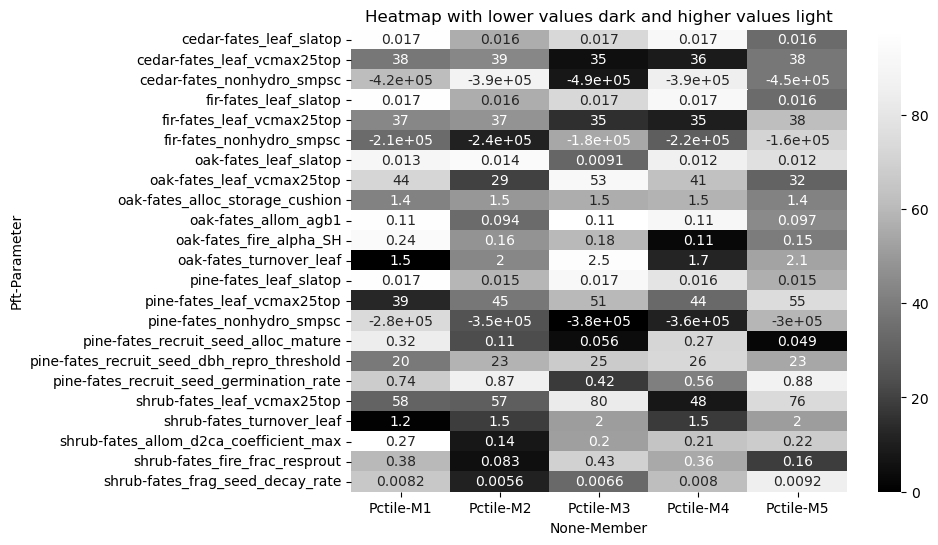

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_piv_pct, cmap='Greys_r', annot=df_piv_val,)
plt.title('Heatmap with lower values dark and higher values light')
plt.show()

In [25]:
df_pivot = pct_df.pivot_table(index=['Parameter', 'Pft'], columns='Member', values=['Pctile'], aggfunc='first')

# Flatten the MultiIndex columns
df_pivot.columns = [f'{val}_{member}' for val, member in df_pivot.columns]

# Reset the index to turn it back into a regular DataFrame
df_pivot.reset_index(inplace=True)

In [24]:
df_pivot

,Parameter,Pft,Value_1,Value_2,Value_3,Value_4,Value_5
0,fates_alloc_storage_cushion,5,1.403496,1.463255,1.525872,1.541528,1.402936
1,fates_allom_agb1,5,0.110414,0.094015,0.110681,0.108780,0.096796
2,fates_allom_d2ca_coefficient_max,4,0.266563,0.139321,0.198996,0.214367,0.221263
3,fates_fire_alpha_SH,5,0.240857,0.164695,0.183270,0.105017,0.154462
4,fates_fire_drying_ratio,0,60160.354378,54182.003438,62811.273688,46184.653986,65507.840194
5,fates_fire_frac_resprout,4,0.383787,0.082961,0.433492,0.357291,0.160318
6,fates_frag_maxdecomp,0,1.094595,1.136992,0.608875,1.073547,0.887425
7,fates_frag_seed_decay_rate,4,0.008244,0.005596,0.006625,0.008034,0.009226
8,fates_leaf_slatop,1,0.016928,0.015374,0.016748,0.016235,0.015271
9,fates_leaf_slatop,2,0.016991,0.016493,0.016767,0.016953,0.015924


In [21]:

targets = df['fates_turnover_leaf_4']
find_closest_indices(percentiles, targets)

,value,percentile
0,1.972497,46
1,2.437877,79
2,2.046974,52
3,2.613000,93
4,2.473262,82
...,...,...
2299,2.478218,83
2300,1.541431,19
2301,2.504541,85
2302,2.553645,88


In [9]:
df['fates_leaf_vcmax25top_5'].max()

57.97882903996656

In [ ]:
find_closest_indices(